In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch_optimizer as optim
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time

from model import ConvNet_Shallow_Single as ConvNet_SS
from model import ConvNet 


import sys

import fasttext.CustomDataset as CustomDataset

/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs4/ushashi/anaconda3/envs/gp

In [2]:
LEARNINGRATE = 3e-3
GAMMA = 0.98

BATCHSIZE = 512
NUMEPOCHS = 12


dset = CustomDataset.get_dataset('data/train.csv')
tset = CustomDataset.get_dataset('data/test.csv')

print('''
0 - World
1 - Sports
2 - Business
3 - Sci/Tech
''')

### TRAIN VAL SPLIT

NUM_DATA_POINTS = len(dset)

indices = list(range(NUM_DATA_POINTS))
split = int(np.floor(0.2 * NUM_DATA_POINTS))
np.random.shuffle(indices)

print(indices[0])


train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_points = len(train_indices)
val_points = len(val_indices)

train_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE,
                                                sampler=valid_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(tset, batch_size = BATCHSIZE,
                                                num_workers=4)

print("Printing Train + Val Number of Documents Found")
print(NUM_DATA_POINTS)


0 - World
1 - Sports
2 - Business
3 - Sci/Tech

23848
Printing Train + Val Number of Documents Found
120000


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_slave = ConvNet_SS(True, WINDOW=3)
print('Running on',device)
print('Building Slave model..')
model_slave.to(device)
print('Model Built.')

FILE = 'fasttext/sw-2/Model_best_val_quicksave.pt'

model_slave.load_state_dict(torch.load(FILE,map_location='cuda:0'))
model_slave.eval()


print('Initializing optimizer and scheduler..')

criterion = torch.nn.NLLLoss()
optimizer = optim.RAdam(model_slave.parameters(), lr = LEARNINGRATE)             # OR RAdam/DiffGrad/etc
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = GAMMA)

print('Optimizer and scheduler initialized.')

print('Printing Parameters')
for name, param in model_slave.named_parameters():
    if param.requires_grad:
        print(name)
print('---Printing Parameters Finished!---')


Running on cuda:0
Building Slave model..
Model Built.
Initializing optimizer and scheduler..
Optimizer and scheduler initialized.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
---Printing Parameters Finished!---


In [4]:
model_master = ConvNet(True, WINDOW=3)
print('Running on',device)
print('Building Master model..')
model_master.to(device)
print('Model Built.')

FILE_MASTER = 'fasttext/weights_2/Model_quicksave5.pt'

model_master.load_state_dict(torch.load(FILE_MASTER,map_location='cuda:0'))
model_master.eval()


print('Printing Parameters')
for name, param in model_master.named_parameters():
    if param.requires_grad:
        print(name)
        #print(param.shape)
print('---Printing Parameters Finished!---')

Running on cuda:0
Building Master model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
---Printing Parameters Finished!---


In [5]:
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model_slave(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy Slave: {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy Slave: 81.08%


In [6]:
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model_master(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy Master: {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy Master: 91.12%


In [7]:
from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1024,(3,300),activation='relu', name='conv1')(inp)
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(256,name='fc1',activation='relu')(x)
    z = Dropout(0.25)(x)
    ou = Dense(32,name='fc2',activation='relu')(z)
    ou = Dropout(0.3)(ou)
    out = Dense(4,name='fc3')(ou)
    outz = Dropout(0.2)(out)
    k_model = Model(inp, outz)


trained_weights = model_master.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

channels_last
['conv1' 'fc1' 'fc2' 'fc3']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1024)     922624    
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None

In [8]:
method = ("lrp.z",{},"LRP-Z")
         
analyzer = innvestigate.create_analyzer(method[0], k_model,neuron_selection_mode="index",**method[1]) #neuron_selection_mode="index",  


analyzis = [None]*train_points

for i in range(train_points):
 
    index = train_indices[i]
    x = dset[index]['matrix']
    y = dset[index]['class']
    x = x.reshape((1, -1, 300,1)).numpy()    
    analyzis[i] = np.zeros(x.shape[1])
    
    a = np.squeeze(analyzer.analyze(x,neuron_selection=y))
    a = np.sum(a, axis=1)
    analyzis[i] = a   

In [9]:
np.save('lrp_maps_training_for_MS.npy',analyzis)

In [11]:
top_n = 6
fraction_zeroed = 5 #(out of 8) 
num = fraction_zeroed
min_val_loss = float('inf')

loss_values_train = []
loss_values_val = []

BATCHSIZE = 8*64
print('Batch Size = ',BATCHSIZE)

for epoch in range(1,NUMEPOCHS+1):
    start_time = time.time()
    
    model_slave.train()
    runloss = 0.0
    tacc = 0
    
    if epoch%2 == 1:
        mode = 'Forced Epoch'
        for i in range((train_points)//64):
            
            #if i%100==0:
            #    print(i)
            
            data_input = np.zeros((BATCHSIZE,1,80,300))
            data_output = np.zeros(BATCHSIZE)
            
            for j in range(64):
                index = train_indices[64*i+j]
                sample = dset[index]
            
                data = sample['matrix'][None,None,:,:].numpy()
                data = np.tile(data,(8,1,1,1))
                
                order = np.argsort(analyzis[i])[::-1]
                data[:num,:,order[:top_n],:] = np.zeros((num,1,top_n,300)) 
                
                data_input[j*8:(j+1)*8] = data
                
                data = sample['class'][0].numpy()
                data = np.tile(data,(8))
                
                data_output[j*8:(j+1)*8] = data
            
            data_input = torch.as_tensor(data_input)
            data_output = torch.as_tensor(data_output)
            
            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model_slave(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= (train_points*8) 
        tacc = tacc*100.0/ (train_points*8)

        loss_values_train.append(runloss)
        
        
    if epoch%2 == 0:    
        mode = 'Unforced Epoch'
        for ib,sample in enumerate(train_loader):

            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model_slave(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= train_points 
        tacc = tacc*100.0/ train_points

        loss_values_train.append(runloss)
    
    model_slave.eval()

    val_loss = 0
    corr = 0
    
    with torch.no_grad():
        for ib,sample in enumerate(validation_loader):
            
            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)
            data_output = data_output.to(device, dtype=torch.long)

            output = model_slave(data_input)
            _, preds = torch.max(output,dim=1)
            
            loss = criterion(output, data_output)
            val_loss += loss.item()* data_input.size(0)
            corr += (torch.sum(preds == data_output.data)).data.item()
            
    val_loss /= val_points
    corr = corr*100.0/val_points
    loss_values_val.append(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        torch.save(model_slave.state_dict(), 'fasttext/integrated_NEG/Model_best_val_quicksave.pt')
    
    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    

    print('epoch [{}/{}] '.format(epoch, NUMEPOCHS)+mode+' loss:{:.7f}, train acc:{:.4f}, val loss:{:.7f}, val acc:{:.4f} in {}h {}m {}s'.format(
                                                                                runloss, tacc, val_loss, corr,
                                                                                time_el//3600,
                                                                                (time_el%3600)//60,
                                                                               time_el%60))
    
    torch.save(model_slave.state_dict(), 'fasttext/integrated_NEG/Model_quicksave'+str(epoch)+'.pt')
    scheduler.step()
    

Batch Size =  512
epoch [1/12] Forced Epoch loss:0.6955417, train acc:71.4323, val loss:0.5515336, val acc:80.2500 in 0h 4m 24s
epoch [2/12] Unforced Epoch loss:0.6608869, train acc:72.8490, val loss:0.5288189, val acc:81.0292 in 0h 0m 46s
epoch [3/12] Forced Epoch loss:0.7027491, train acc:71.0583, val loss:0.5491110, val acc:80.0917 in 0h 4m 25s
epoch [4/12] Unforced Epoch loss:0.6612327, train acc:72.6677, val loss:0.5280217, val acc:81.0792 in 0h 0m 47s
epoch [5/12] Forced Epoch loss:0.6955125, train acc:71.4451, val loss:0.5440309, val acc:80.6250 in 0h 4m 24s
epoch [6/12] Unforced Epoch loss:0.6566889, train acc:72.8948, val loss:0.5270235, val acc:81.1042 in 0h 0m 46s
epoch [7/12] Forced Epoch loss:0.6928938, train acc:71.4979, val loss:0.5394128, val acc:80.5792 in 0h 4m 23s
epoch [8/12] Unforced Epoch loss:0.6565905, train acc:72.8979, val loss:0.5275760, val acc:81.0958 in 0h 0m 47s
epoch [9/12] Forced Epoch loss:0.6902393, train acc:71.5841, val loss:0.5417261, val acc:80.42

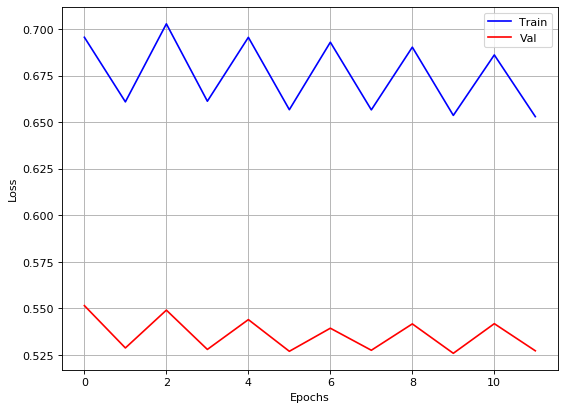

In [12]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(loss_values_train), 'b')
plt.plot(np.array(loss_values_val), 'r')
plt.legend(['Train','Val'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [13]:
model_slave.eval()
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model_slave(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy Slave: {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy Slave: 80.62%


In [17]:
model_slave = ConvNet_SS(True, WINDOW=3)
print('Running on',device)
print('Building Slave model..')
model_slave.to(device)
print('Model Built.')

FILE = 'fasttext/sw-2/Model_best_val_quicksave.pt'

model_slave.load_state_dict(torch.load(FILE,map_location='cuda:0'))
model_slave.eval()


print('Initializing optimizer and scheduler..')

criterion = torch.nn.NLLLoss()
optimizer = optim.RAdam(model_slave.parameters(), lr = LEARNINGRATE)             # OR RAdam/DiffGrad/etc
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = GAMMA)

print('Optimizer and scheduler initialized.')

print('Printing Parameters')
for name, param in model_slave.named_parameters():
    if param.requires_grad:
        print(name)
print('---Printing Parameters Finished!---')


LEARNINGRATE = 3e-3
GAMMA = 0.92

Running on cuda:0
Building Slave model..
Model Built.
Initializing optimizer and scheduler..
Optimizer and scheduler initialized.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
---Printing Parameters Finished!---


In [18]:
top_n = 3
min_val_loss = float('inf')

loss_values_train = []
loss_values_val = []

BATCHSIZE = 512
print('Batch Size = ',BATCHSIZE)

for epoch in range(1,NUMEPOCHS+1):
    start_time = time.time()
    
    model_slave.train()
    runloss = 0.0
    tacc = 0
    
    if epoch%2 == 1:
        mode = 'Forced Epoch'
        for i,sample in enumerate(train_loader):
            
            data_input = sample['matrix'][:,None,:,:].numpy()
            data_output = sample['class'][:,0].numpy()
            
            for j in range(BATCHSIZE):
                #print(len(analyzis))
                #print(BATCHSIZE*i+j)
                try:
                    order = np.argsort(analyzis[BATCHSIZE*i+j])[::-1]
                except IndexError as error:
                    break
                    
                for k in order[:top_n]:
                    data_input[j,:,k,:] = np.zeros((1,1,1,300)) 
                
            
            data_input = torch.as_tensor(data_input)
            data_output = torch.as_tensor(data_output)
            
            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model_slave(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= (train_points) 
        tacc = tacc*100.0/ (train_points)

        loss_values_train.append(runloss)
        
        
    if epoch%2 == 0:    
        mode = 'Unforced Epoch'
        for ib,sample in enumerate(train_loader):

            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model_slave(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= train_points 
        tacc = tacc*100.0/ train_points

        loss_values_train.append(runloss)
    
    model_slave.eval()

    val_loss = 0
    corr = 0
    
    with torch.no_grad():
        for ib,sample in enumerate(validation_loader):
            
            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)
            data_output = data_output.to(device, dtype=torch.long)

            output = model_slave(data_input)
            _, preds = torch.max(output,dim=1)
            
            loss = criterion(output, data_output)
            val_loss += loss.item()* data_input.size(0)
            corr += (torch.sum(preds == data_output.data)).data.item()
            
    val_loss /= val_points
    corr = corr*100.0/val_points
    loss_values_val.append(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        torch.save(model_slave.state_dict(), 'fasttext/integrated-v2_NEG/Model_best_val_quicksave.pt')

    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    

    print('epoch [{}/{}] '.format(epoch, NUMEPOCHS)+mode+' loss:{:.7f}, train acc:{:.4f}, val loss:{:.7f}, val acc:{:.4f} in {}h {}m {}s'.format(
                                                                                runloss, tacc, val_loss, corr,
                                                                                time_el//3600,
                                                                                (time_el%3600)//60,
                                                                               time_el%60))
    
    torch.save(model_slave.state_dict(), 'fasttext/integrated-v2_NEG/Model_quicksave'+str(epoch)+'.pt')
    scheduler.step()
    

Batch Size =  512
epoch [1/12] Forced Epoch loss:0.6630187, train acc:72.5812, val loss:0.5209336, val acc:81.2583 in 0h 0m 47s
epoch [2/12] Unforced Epoch loss:0.6445439, train acc:73.4417, val loss:0.5239884, val acc:81.0708 in 0h 0m 47s
epoch [3/12] Forced Epoch loss:0.6669710, train acc:72.4760, val loss:0.5242626, val acc:81.2167 in 0h 0m 47s
epoch [4/12] Unforced Epoch loss:0.6513705, train acc:72.9990, val loss:0.5244388, val acc:81.1625 in 0h 0m 47s
epoch [5/12] Forced Epoch loss:0.6697106, train acc:72.3083, val loss:0.5257279, val acc:81.2542 in 0h 0m 46s
epoch [6/12] Unforced Epoch loss:0.6479767, train acc:73.2615, val loss:0.5260086, val acc:81.0083 in 0h 0m 47s
epoch [7/12] Forced Epoch loss:0.6644874, train acc:72.6177, val loss:0.5232888, val acc:81.1833 in 0h 0m 47s
epoch [8/12] Unforced Epoch loss:0.6470666, train acc:73.2885, val loss:0.5211583, val acc:81.1958 in 0h 0m 47s
epoch [9/12] Forced Epoch loss:0.6668837, train acc:72.6312, val loss:0.5222231, val acc:81.16

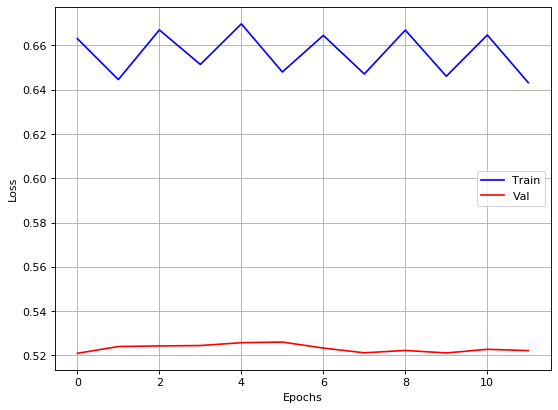

In [19]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(loss_values_train), 'b')
plt.plot(np.array(loss_values_val), 'r')
plt.legend(['Train','Val'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [20]:
model_slave.eval()
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model_slave(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy Slave: {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy Slave: 80.59%
